In [ ]:
!pip install numpy pandas matplotlib seaborn scikit-learn nltk wordcloud


In [ ]:
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# NLP
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# ML
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

nltk.download("stopwords")
nltk.download("wordnet")

sns.set_style("darkgrid")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


Load Dataset

In [ ]:
df = pd.read_csv("climate_nasa.csv")
df.head()

Getting Dataset

In [ ]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 522 entries, 0 to 521
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           522 non-null    object 
 1   likesCount     522 non-null    int64  
 2   profileName    522 non-null    object 
 3   commentsCount  244 non-null    float64
 4   text           504 non-null    object 
dtypes: float64(1), int64(1), object(3)
memory usage: 20.5+ KB


EDA Started

In [ ]:
print("Total comments:", len(df))


Total comments: 522


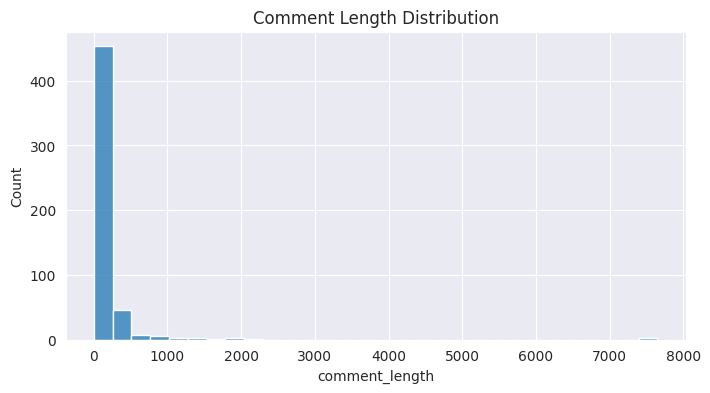

In [ ]:
# Comment length
df["comment_length"] = df["Text"].astype(str).apply(len)

plt.figure(figsize=(8,4))
sns.histplot(df["comment_length"], bins=30)
plt.title("Comment Length Distribution")
plt.show()



In [ ]:
df.columns
print(list(df.columns))


['date', 'likesCount', 'profileName', 'commentsCount', 'text']


In [ ]:
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+", "", text)
    text = re.sub(r"[^a-z\s]", "", text)
    words = text.split()
    words = [lemmatizer.lemmatize(w) for w in words if w not in stop_words]
    return " ".join(words)

df["clean_text"] = df["Text"].apply(clean_text)


In [ ]:
df[["Text", "clean_text"]].head()


,Text,clean_text
0,Neat comparison I have not heard it before.\n ...,neat comparison heard would say co like disco ...
1,An excellent way to visualise the invisible! T...,excellent way visualise invisible thanks
2,Does the CO2/ghg in the troposphere affect the...,coghg troposphere affect stratosphere warmer t...
3,excellent post! I defo feel the difference - o...,excellent post defo feel difference one drink ...
4,"Yes, and carbon dioxide does not harm the Eart...",yes carbon dioxide harm earth like people maki...


In [ ]:
df.columns


Index(['date', 'likesCount', 'profileName', 'commentsCount', 'Text',
       'comment_length'],
      dtype='object')

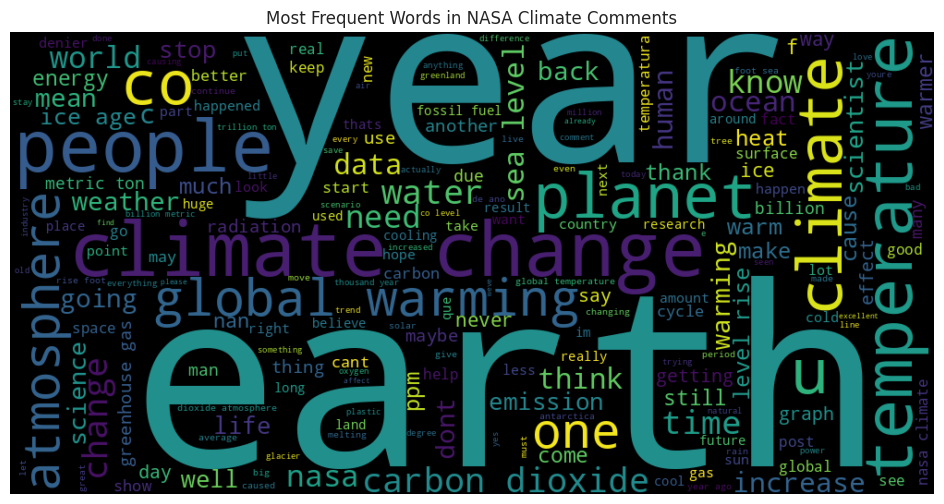

In [ ]:
from wordcloud import WordCloud

all_text = " ".join(df["clean_text"])

wordcloud = WordCloud(
    width=1000,
    height=500,
    background_color="black",
    max_words=200
).generate(all_text)

plt.figure(figsize=(14,6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Most Frequent Words in NASA Climate Comments")
plt.show()


In [ ]:
def assign_sentiment(text):
    positive_words = [
        "true", "real", "science", "support", "important",
        "evidence", "agree", "correct", "right", "fact"
    ]
    negative_words = [
        "fake", "hoax", "lie", "scam", "wrong",
        "false", "nonsense", "myth", "propaganda"
    ]

    pos = sum(word in text for word in positive_words)
    neg = sum(word in text for word in negative_words)

    if pos > neg:
        return "Positive"
    elif neg > pos:
        return "Negative"
    else:
        return "Neutral"


In [ ]:
df["sentiment"] = df["clean_text"].apply(assign_sentiment)
df["sentiment"].value_counts()


,count
sentiment,
Neutral,424
Positive,78
Negative,20


In [ ]:
sentiment_map = {
    "Negative": 0,
    "Neutral": 1,
    "Positive": 2
}

df["sentiment_encoded"] = df["sentiment"].map(sentiment_map)


In [ ]:
df[["Text", "sentiment", "sentiment_encoded"]].head()


,Text,sentiment,sentiment_encoded
0,Neat comparison I have not heard it before.\n ...,Neutral,1
1,An excellent way to visualise the invisible! T...,Neutral,1
2,Does the CO2/ghg in the troposphere affect the...,Neutral,1
3,excellent post! I defo feel the difference - o...,Neutral,1
4,"Yes, and carbon dioxide does not harm the Eart...",Negative,0


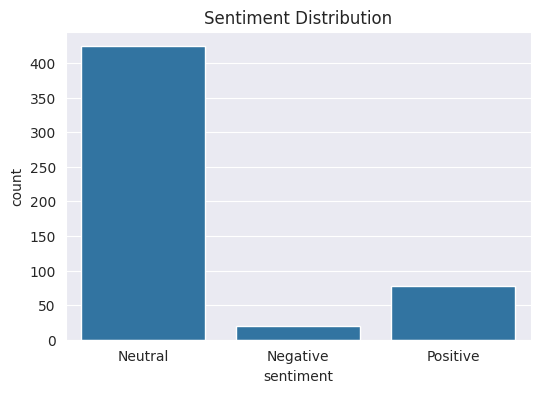

In [ ]:
plt.figure(figsize=(6,4))
sns.countplot(x="sentiment", data=df)
plt.title("Sentiment Distribution")
plt.show()


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

X = df["clean_text"]
y = df["sentiment_encoded"]

vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1,2)
)

X_tfidf = vectorizer.fit_transform(X)


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [ ]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)


LogisticRegression(max_iter=1000)

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))


Accuracy: 0.8095238095238095

Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.81      1.00      0.89        85
           2       0.00      0.00      0.00        16

    accuracy                           0.81       105
   macro avg       0.27      0.33      0.30       105
weighted avg       0.66      0.81      0.72       105



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


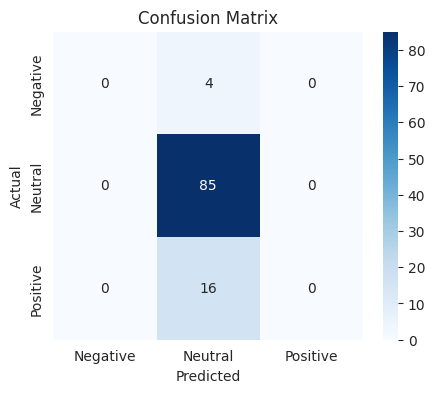

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Negative","Neutral","Positive"],
            yticklabels=["Negative","Neutral","Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
def predict_sentiment(comment):
    cleaned = clean_text(comment)
    vector = vectorizer.transform([cleaned])
    prediction = model.predict(vector)[0]

    label_map = {0:"Negative", 1:"Neutral", 2:"Positive"}
    return label_map[prediction]


In [ ]:
predict_sentiment("Climate change is real and NASA provides scientific evidence")


'Positive'

In [ ]:
df.to_csv("nasa_climate_sentiment_final.csv", index=False)


In [ ]:
import joblib

joblib.dump(model, "sentiment_model.pkl")
joblib.dump(vectorizer, "tfidf_vectorizer.pkl")


['tfidf_vectorizer.pkl']

In [ ]:
import joblib
joblib.dump(model, "sentiment_model.pkl")
joblib.dump(vectorizer, "tfidf_vectorizer.pkl")


['tfidf_vectorizer.pkl']

In [ ]:
import joblib

model = joblib.load("sentiment_model.pkl")
vectorizer = joblib.load("tfidf_vectorizer.pkl")

def predict_sentiment(comment):
    clean = clean_text(comment)
    vec = vectorizer.transform([clean])
    prediction = model.predict(vec)[0]
    return {0:"Negative", 1:"Neutral", 2:"Positive"}[prediction]

predict_sentiment("Climate change is real and backed by science")


'Positive'